<a href="https://colab.research.google.com/github/Hf301/Hf301/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# установка моделей сегментации
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00


In [ ]:
# Установим необходимые библиотеки
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from IPython.display import clear_output
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: длина выполнения в строковом формате (начальная длина)
    форма: (высота,ширина) возвращаемого массива.
    Возвращает массив numpy array, 1 - mask, 0 - background.
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Возвращает длину выполнения в виде строки, сформированной
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_mask(image_id, df):
    '''
    Использует rle_decode() для получения ndarray из маски, используя image_id в dataframe (df).
    '''
    current = df[df["id"] == image_id]
    labels = current["annotation"].tolist()
    mask = np.zeros((HEIGHT, WIDTH))
    for label in labels:
        mask += rle_decode(label, (HEIGHT, WIDTH))
    mask = mask.clip(0, 1)
    return mask

#  Оптимизация текстур:
def check_overlap(msk):
    '''
    Проверяет, есть ли перекрытия в маске (msk).
    '''
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)

def fix_overlap(msk):
    '''
    Аргументы:
        маска: многоканальная маска, каждый канал является экземпляром ячейки, форма:(520,704,None)
    Возвращается:
        многоканальная маска с неперекрывающимися значениями, форма::(520,704,None).
    '''
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

# прогнозы для тестового набора:
def make_predictions(dataset, num, keras_model, check_overlaps=False):
    '''
    Для tf.Dataset делает прогнозы для n =num (num =-1 или all_images принимает все изображения в наборе данных),
    изображения с использованием keras_model. Возвращает список предсказанных масок, каждая в виде ndarray.
    '''
    predictions = []
    if dataset:
        for image in dataset.take(num):
            image = image[None]
            pred_mask = keras_model.predict(image)
            # меняет форму от (1,512,512,1) до (512,512)
            pred_mask = pred_mask[0, :, :, 0]
            # Оптимизация текстур:
            if check_overlaps:
                if check_overlap(msk=pred_mask):
                    pred_mask = pred_mask[None]
                    pred_mask = fix_overlap(msk=pred_mask)
            # преобразует значения ndarray в 0s и 1s
            pred_mask =  np.where( pred_mask > 0.5, 1, 0)
            predictions.append(pred_mask)
    return predictions


def display(display_list):
    '''
    Отображает пример изображения и маски 
    '''
    plt.figure(figsize=(20, 20))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# функции для визуализации прогнозов:
def create_mask(pred_mask):
    '''
    Преобразует прогнозируемые значения маски в 0s и 1s
    '''
    pred_mask = tf.where(pred_mask > 0.5,1,0)
    return pred_mask

def show_predictions(keras_model, dataset=None, num=1):
    '''
    Показывает N=num примеров предсказаний из dataset и keras_model
    '''
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = keras_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask[0])])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...])[0])])

In [ ]:
# константы
DEBUG = False
SEED = 123
WIDTH, HEIGHT = 704, 520
RESIZE_WIDTH, RESIZE_HEIGHT = 512, 512
BATCH_SIZE = 4
BUFFER_SIZE = 32
# в задаче сегментации каждому пикселю присваивается класс
# OUTPUT_CLASSES: количество классов, которые могут быть назначены каждому пикселю 
OUTPUT_CLASSES = 1
# основа архитектуры для модели сегментации
BACKBONE = 'densenet121'
VAL_SPLIT = 0.1
AUTO = tf.data.AUTOTUNE
EPOCHS = 50

In [ ]:
# Устанавливаем библиотеку Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Создаём каталог с именем “.kaggle”:
! mkdir ~/.kaggle

In [ ]:
# Копируем файл “kaggle.json” в созданный каталог:
! cp kaggle.json ~/.kaggle/

In [ ]:
# Назнаем необходимое разрешение для этого файла:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Загрузка набора данных:
! kaggle competitions download -c sartorius-cell-instance-segmentation

 99% 2.29G/2.31G [00:19<00:00, 160MB/s]
100% 2.31G/2.31G [00:19<00:00, 128MB/s]


In [ ]:
# Извлекаем данные:
! unzip /content/sartorius-cell-instance-segmentation.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d00h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/

In [ ]:
# вход
DIR = '../input/sartorius-cell-instance-segmentation'
train_csv = '/content/train.csv'
train_path = '/content/train'
test_path = '/content/test'
# выход 
csv_output = os.path.join('./', 'submission.csv') 
model_output = os.path.join('./', 'unet_keras_' + BACKBONE + '_backbone.h5')

In [ ]:
# разделение обучения и проверки
train = pd.read_csv(train_csv)
train.head()
n_ids = train.id.nunique()

if DEBUG:
    unique_ids_train = list(set(train['id'].tolist()))[:BATCH_SIZE]
    unique_ids_valid = list(set(train['id'].tolist()))[BATCH_SIZE:2*BATCH_SIZE]
else:
    unique_ids_train = list(set(train['id'].tolist()))[:int(n_ids * (1 - VAL_SPLIT))]
    unique_ids_valid = list(set(train['id'].tolist()))[int(n_ids * (1 - VAL_SPLIT)):]

temp = pd.DataFrame()
for sample_id in unique_ids_train:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
train = temp
train = train.reset_index(drop=True)

temp = pd.DataFrame()
for sample_id in unique_ids_valid:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
valid = temp
valid = train.reset_index(drop=True)
    
TRAIN_LENGTH = train['id'].nunique()
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VALID_LENGTH = valid['id'].nunique()
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE

In [ ]:
# генератор валидационных данных

preprocess_input = get_preprocessing(BACKBONE)

def train_generator(df):
    image_ids = set(df['id'].tolist())
    
    for image_id in image_ids:
        
        image = cv2.imread(os.path.join(train_path, image_id) + '.png')
        image = preprocess_input(image)
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))

        mask = get_mask(image_id, df)        
        mask = cv2.resize(mask, (RESIZE_HEIGHT, RESIZE_WIDTH))
        
        mask = mask.reshape((*mask.shape, 1))
        
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        
        yield image, mask

In [ ]:
# использую генератор для получения обучающих и проверочных наборов
train_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(train), 
    output_types=(tf.float32, tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))

valid_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(valid), 
    output_types=(tf.float32, tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))

In [ ]:
# следующий класс выполняет простое увеличение путем случайного переворачивания изображения
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=SEED):
        super().__init__()
        
        self.augment_inputs = preprocessing.RandomFlip('horizontal', seed=seed)
        self.augment_labels = preprocessing.RandomFlip('horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [ ]:
# создаю конвейер ввода, применив дополнение после пакетной обработки входных данных

train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(AUTO))

valid_ds = (
    valid_ds
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO))

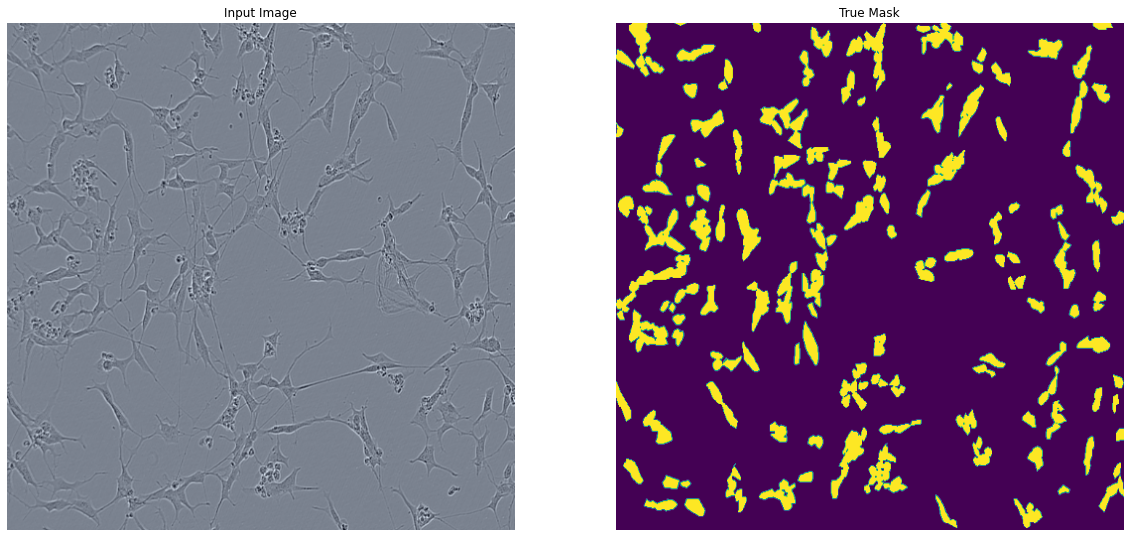

In [ ]:
# визуализирую пример изображения и соответствующую ему маску из набора данных   
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [ ]:
# определение модели

# encoder_freeze: если True, устанавливаю все уровни encoder (базовая модель) как не поддающиеся обучению
model = Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet', 
                activation='sigmoid',
                classes=OUTPUT_CLASSES,
                encoder_freeze=True)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# оптимизатор
opt = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss=bce_jaccard_loss,
              metrics=[iou_score])

1/1 [==============================] - 0s 33ms/step


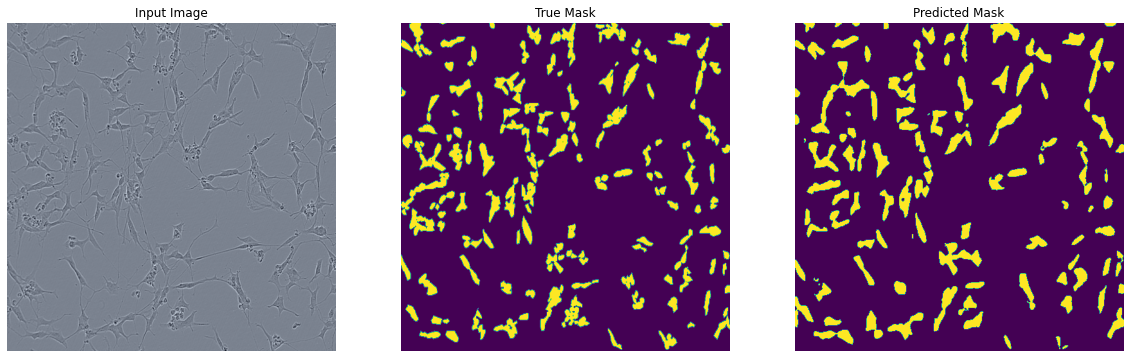


Sample Prediction after epoch 50

136/136 [==============================] - 92s 681ms/step - loss: 0.4474 - iou_score: 0.6649 - val_loss: 0.4554 - val_iou_score: 0.6598 - lr: 0.0010


In [ ]:
# обучение
# следим, как модель совершенствуется во время тренировки
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=False)
        show_predictions(keras_model=model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
display_cb = DisplayCallback()


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_output,
    save_best_only=True,
    save_weights_only=False,
)

# снизить скорость обучения, когда показатель перестал улучшаться.
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_ds,
                          callbacks=[display_cb, model_checkpoint, lr_reduce])

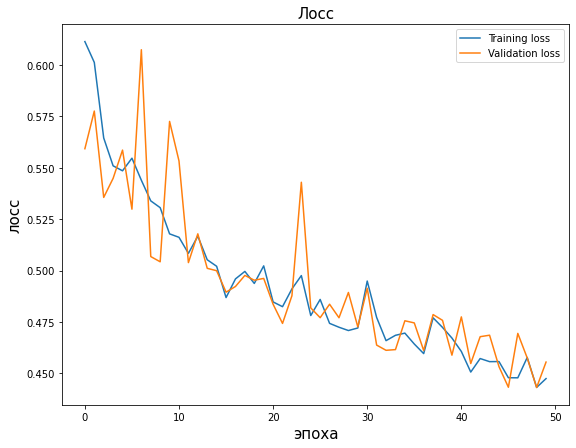

In [ ]:
# # построим график обучения
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
fig = plt.figure(figsize=(20, 7))
plt.subplot(1,2,1)
plt.title('Лосс', fontsize=15)
plt.plot(model_history.epoch, loss, label='Training loss')
plt.plot(model_history.epoch, val_loss, label='Validation loss')
plt.ylabel('лосс', fontsize=15)
plt.xlabel('эпоха', fontsize=15)
plt.legend()
plt.show()

In [ ]:
# генератор тестовых данных
test_ids = [  os.path.join(test_path, each)  for each in os.listdir(test_path) if each.endswith('.png')]
def test_generator(image_ids):
    for image_id in image_ids:
        image = cv2.imread(image_id) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
        image = image.astype(np.float32)
        yield image

In [ ]:
# тестовый набор данных из генератора тестовых данных 
test_ds = tf.data.Dataset.from_generator(
    lambda : test_generator(test_ids), 
    output_types=(tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3)) )

In [ ]:
# тестовые идентификаторы изображений и прогнозы
test_predictions = make_predictions(dataset=test_ds, 
                                    num=len(test_ids), 
                                    keras_model=model,
                                    check_overlaps=True)

1/1 [==============================] - 0s 31ms/step


<ipython-input-26-ccdfc50bfd24>:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  msk = msk.astype(np.bool).astype(np.uint8)


In [ ]:
# прогнозы в формате RL
test_predictions = [rle_encode(mask) for mask in test_predictions] 

In [ ]:
# преобразуйте полные пути к изображениям в идентификаторы
test_ids = [Path(ID).stem for ID in test_ids]

In [ ]:
# фрейм данных отправки
submisssion = pd.DataFrame.from_dict({'id': test_ids, 'predicted': test_predictions} )
submisssion = submisssion.sort_values( ['id'], ascending=True )
print(submisssion.head(), 'n')
submisssion.to_csv(csv_output, index=False)

             id                                          predicted
2  7ae19de7bc2a  5 1 10 1 27 1 36 1 45 1 54 1 63 1 70 1 79 1 88...
1  d48ec7815252  2 1 7 1 18 1 24 1 30 1 36 1 40 1 46 1 54 1 60 ...
0  d8bfd1dafdc4  3 1 7 1 18 1 24 1 30 1 36 1 42 1 48 1 54 1 60 ... n
